<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/randomforest/regression/03_random_forest_sales_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RepeatedKFold,
    ParameterGrid,
    cross_val_score
)

from sklearn.inspection import permutation_importance


import multiprocessing

import warnings
warnings.filterwarnings('ignore')

# **Config**
---

In [150]:
sns.set(style="darkgrid")

# **Description**
---
El dataset Boston contiene precios de viviendas de la ciudad de Boston, asi como información socio-economica del barrio en el que se encunetran.

#**Objetivo**
---
Se pretende ajustar un modelo de regresión que permita predecir el precio medio de una vivienda MEDV en función de las variables disponibles.

# **Diccionario de datos**
---

Número de instancias: 506

- `CRIM`: tasa de criminalidad per cápita por ciudad
- `ZN`: proporción de suelo residencial zonificado para lotes de más de 25,000 pies cuadrados.
- `INDUS`: proporción de acres comerciales no minoristas por ciudad
- `CHAS`: variable ficticia del río Charles (= 1 si el tramo limita con el río; 0 en caso contrario)
- `NOX`: concentración de óxidos nítricos (partes por 10 millones)
- `RM`: promedio de cuartos por vivienda
- `EDAD`: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- `DIS`: distancias ponderadas a cinco centros de empleo de Boston
- `RAD`: índice de accesibilidad a las carreteras radiales
- `IMPUESTO`: tasa de impuesto a la propiedad de valor total por $ 10,000

- `PTRATIO`: ratio alumno-profesor por municipio
- `LSTAT`: % estado inferior de la población
- `MEDV`: valor medio de las viviendas ocupadas por sus propietarios en $ 1000

# **Diccionario de datos**
---

In [151]:
url="https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

In [152]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# **Info**
---

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


# **Split**
---

In [154]:
X = data.drop(['medv'], axis=1)
y = data['medv']

In [155]:
data.shape[0]*0.25

126.5

In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.85,
    random_state = 12354,
    shuffle=True
)

# **Functions**
---

In [157]:
def create_model(**kward)->object:
  model = RandomForestRegressor(
      **kward
  )
  return model

In [158]:
# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento .

def training_validation_loop(
    model: object,
    estimator_range: range,
    X_train: pd.core.frame.DataFrame,
    y_train: pd.core.series.Series,
)->tuple:
  train_scores, score = [], []
  for n_estimator in estimator_range:
    mdel = model
    mdel.n_estimators = n_estimator
    mdel.fit(X_train, y_train)

    if model.oob_score:
      train_scores.append(
          mdel.score(X_train, y_train)
      )

      score.append(mdel.oob_score_)
    else:
      y_predict = mdel.predict(X_train)
      rmse = mean_squared_error(
          y_train,
          y_predict,
          squared=False
      )
      train_scores.append(rmse)
      scores = cross_val_score(
          estimator = mdel,
          X = X_train,
          y = y_train,
          scoring = 'neg_root_mean_squared_error',
          cv = 10
      )
      score.append(-1*scores.mean())
  return train_scores, score

In [159]:
def error_vs_nstimators(
    train_scores:list,
    score:list,
    estimator_range:range,
    figsize:tuple = (10, 4),
    **kward
    )->None:
  d = kward
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot(estimator_range, train_scores, label=d['X_label'])
  ax.plot(estimator_range, score, label=d['y_label'])
  ax.plot(estimator_range[np.argmax(score)], max(score),
        marker='o', color='red', label='max score')
  ax.set_ylabel("R^2")
  ax.set_xlabel("n_estimators")
  ax.set_title(d['title'])
  plt.legend();
  print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(score)]}")
  plt.show()

#**Model**
---

In [160]:
dic_params = {
    "n_estimators":100, #Numero de arboles incluido en el modelo
    "criterion":'squared_error',
    "max_depth":None, #profundidad máxima que pueden alcanzar los árboles.
    "max_features":'auto', # Numero de caracteristicas
    "oob_score":True, # Si se calcula o no el out-of-bag R^2.
    "n_jobs":-1,
    "random_state":12354
}

In [161]:
model = create_model(**dic_params)

In [162]:
model

RandomForestRegressor(max_features='auto', n_jobs=-1, oob_score=True,
                      random_state=12354)

In [163]:
type(model)

sklearn.ensemble._forest.RandomForestRegressor

In [164]:
model.fit(X_train, y_train)

RandomForestRegressor(max_features='auto', n_jobs=-1, oob_score=True,
                      random_state=12354)

In [165]:
model.score(X_train, y_train)

0.9814433652142011

- A partir del coeficiente de determinacion, se puede ver que el modelo se adapta bien a los datos.

In [166]:
y_predict = model.predict(X_test)

In [167]:
squared_error = mean_squared_error(
    y_true = y_test,
    y_pred = y_predict,
    squared=False
)

In [168]:
print(f"The test error is: {squared_error}")

The test error is: 3.0560664001466433


- No es un error pronunciado

# **Seleccion del numero de estimadores**
---

##**Validación empleando el Out-of-Bag error**
---



In [169]:
train_scores = []
oob_scores = []
estimator_range = range(1, 150, 5)

 **max_features**: el valor predeterminado de 1,0 es equivalente a árboles embolsados ​​y se puede lograr más aleatoriedad estableciendo valores más pequeños, por ejemplo, 0,3.

In [170]:
type(y_train)

pandas.core.series.Series

In [171]:
dic_params = {
    "criterion":'squared_error',
    "max_depth":None, #profundidad máxima que pueden alcanzar los árboles.
    "max_features":'auto', # Numero de caracteristicas
    "oob_score":True, # Si se calcula o no el out-of-bag R^2.
    "n_jobs":-1,
    "random_state":12354
}
model = create_model(**dic_params)
train_scores, oob_scores = training_validation_loop(
    model,
    estimator_range,
    X_train,
    y_train
)


In [172]:
np.argmax(oob_scores)

11

In [173]:
estimator_range[np.argmax(oob_scores)]

56

- El numero optimo de estimadores es 56

Valor óptimo de n_estimators: 56


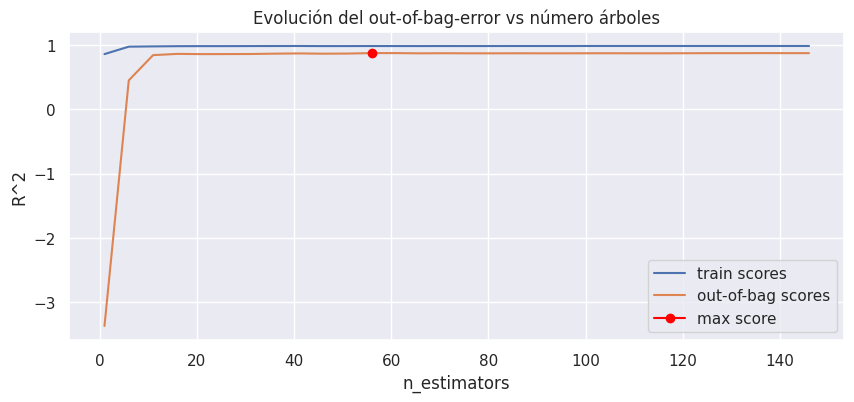

In [174]:
diict_labels = {
    'X_label' : "train scores",
    'y_label' : "out-of-bag scores",
    'title' : "Evolución del out-of-bag-error vs número árboles"
}
error_vs_nstimators(train_scores, oob_scores, estimator_range, **diict_labels)

##**Validación empleando k-cross-validation y neg_root_mean_squared_error**
---

In [175]:
train_scores = []
cv_scores = []
dic_params = {
    'criterion': 'squared_error',
    'max_depth': None,
    'max_features': 'auto',
    'oob_score': False,
    'n_jobs': -1,
    "random_state":12354
}
model = create_model(**dic_params)
train_scores, cv_scores = training_validation_loop(
    model,
    estimator_range,
    X_train,
    y_train
)


Valor óptimo de n_estimators: 136


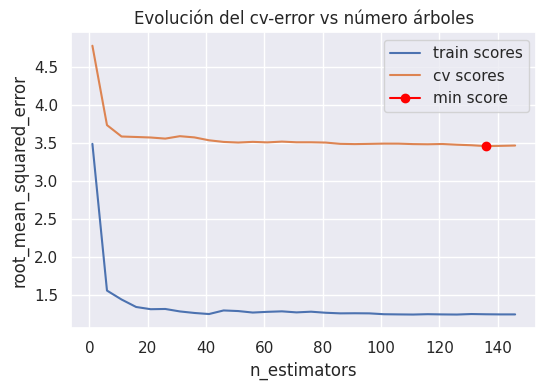

In [177]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Ambas métricas indican que, a partir de entre 56 y 136 árboles, el error de validación del modelo se estabiliza.

# **Max features**
---

El valor de máx_features es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


# **Validación empleando el Out-of-Bag error**
---

In [ ]:
dic_params = {
    "n_estimators": 100,
    "criterion":'squared_error',
    "max_depth":None, #profundidad máxima que pueden alcanzar los árboles.
    "oob_score":True, # Si se calcula o no el out-of-bag R^2.
    "n_jobs":-1,
    "random_state":12354
}

model = create_model(**dic_params)

In [ ]:
train_scores, oob_scores = [], []

# Rango de caracteristicas para tener encuenta decorrelacion
max_feature_range = range(1, X_train.shape[1]+1, 1)
max_feature_range

In [ ]:
for max_feature in max_feature_range:
  model.max_features = max_feature
  model.fit(X_train, y_train)
  train_scores.append(model.score(X_train, y_train))
  oob_scores.append(model.oob_score_)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_feature_range, train_scores, label="train scores")
ax.plot(max_feature_range, oob_scores, label="out-of-bag scores")
ax.plot(max_feature_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_feature_range[np.argmax(oob_scores)]}")

# **Validación empleando k-cross-validation y neg_root_mean_squared_error**
---

In [ ]:
train_scores, cv_scores = [], []
for max_feature in max_feature_range:
  model.max_features = max_feature
  model.fit(X_train, y_train)
  y_predict = model.predict(X_train)
  rmse = mean_squared_error(
      y_train,
      y_predict,
      squared = False
  )
  train_scores.append(rmse)
  scores = cross_val_score(
      model,
      X_train,
      y_train,
      scoring = 'neg_root_mean_squared_error',
      cv = 5
  )
  cv_scores.append(-1*scores.mean())

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_feature_range, train_scores, label="train scores")
ax.plot(max_feature_range, cv_scores, label="cv scores")
ax.plot(max_feature_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_feature_range[np.argmin(cv_scores)]}")

Acorde a las dos métricas utilizadas, el valor óptimo de max_features está entre 9 y 11.

La búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros.

# **Grid Search basado en out-of-bag error**
---


In [ ]:
dict_param = ParameterGrid(
    {'n_estimators': [100, 150, 200],
     'max_features': [5, 8, 11],
     'max_depth': [None, 3, 10, 20]}
)

In [ ]:
resultados = {
    'params': [],
    'oob_r2': []
}

In [ ]:
for params in dict_param:
  model = RandomForestRegressor(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params
      )
  model.fit(X_train, y_train)
  resultados['params'].append(params)
  resultados['oob_r2'].append(model.oob_score_)
  print(f"Modelo: {params} \u2713")

In [ ]:
resultados

In [ ]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat(
    [resultados, resultados['params'].apply(pd.Series)], axis=1)

resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

# **Version Paralelizada**
---

In [ ]:
dict_param

In [ ]:
def eval_oob_error(X, y, model, params, verbose=True)->dict:
  model.set_params(
      oob_score    = True,
      n_jobs       = -1,
      random_state = 123,
      ** params
  )

  model.fit(X, y)

  if verbose:
    print(f"Modelo: {params} \u2713")

  return{'params': params, 'oob_r2': model.oob_score_}

In [ ]:
multiprocessing

In [ ]:
n_jobs = multiprocessing.cpu_count()-1
pool = multiprocessing.Pool(processes=n_jobs)
res = pool.starmap(
    eval_oob_error,
    [
        (X_train, y_train, RandomForestRegressor(), params) for params in dict_param]
)

In [ ]:
resultados = pd.DataFrame(res)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

In [ ]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2", resultados.iloc[0,:])

In [ ]:
model = RandomForestRegressor(
    max_depth = 10,
    max_features = 5,
    n_estimators = 200,
    random_state=12354,
    oob_score = True
)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_predict = model.predict(X_test)
rmse = mean_squared_error(
    y_test,
    y_predict,
    squared = False
)

Optimizando los hiperparametros, se reduce el error rmse de modelo que paso de 3.056066400146643  a 2.916422698173403. Las predicciones del modelo final se alejan en promedio 2.916422698173403 unidades (2916 dolares) del valor final.

In [ ]:
rmse

# **Grid Search basado en validación cruzada**
---

In [ ]:
dict_param =  {'n_estimators': [100, 150, 200],
     'max_features': [5, 8, 11],
     'max_depth': [None, 3, 10, 20]}


In [ ]:
grid = GridSearchCV(
    estimator = RandomForestRegressor(random_state=12354),
    param_grid = dict_param,
    scoring = "neg_root_mean_squared_error",
    n_jobs  = multiprocessing.cpu_count() - 1,
    cv = RepeatedKFold(
        n_splits=5,
        n_repeats=3,
        random_state=12354),
        refit=True,
        verbose=0,
        return_train_score = True
    )


grid.fit(X_train, y_train)

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [ ]:
X_train

In [ ]:
y_test

In [ ]:
model = grid.best_estimator_
y_predict = model.predict(X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_predict,
        squared = False
)

In [ ]:
print(f"El error (rmse) de test es: {rmse}")


Optimizando los hiperparametros, se reduce el error rmse de modelo que paso de 3.056066400146643  a 2.933644998505774. Las predicciones del modelo final se alejan en promedio 2.933644998505774 unidades (2933 dolares) del valor final.